# Installation

In [1]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


# Import Libraries

In [7]:
import os
import cv2
import numpy as np
from sklearn.utils import shuffle
from sklearn import model_selection
from matplotlib import pyplot as plt
from PIL import Image,ImageEnhance

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import  CategoricalCrossentropy
from tensorflow.keras import utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Activation, Flatten, Dense, Dropout, Convolution2D, MaxPooling2D, AveragePooling2D

In [2]:
main_directory = 'dataset'

In [3]:
class_map = {
    "rock": 0,
    "paper": 1,
    "scissors": 2,
    "lizard": 3,
    "spock": 4,
    "nothing": 5
}

# Dataset information:
- 9000 images which consist of 6 categories (each category has 1500 images)
- image sizes: 300x300 and 400x380, will be resized to 300x300
<br/><br/> More info on wiki page

# Load data
Resize images to 300x300 and change color to gray.

In [6]:
dataset = []
for directory in os.listdir(main_directory):
    path = os.path.join(main_directory, directory)
    if not os.path.isdir(path):
        continue
    for item in os.listdir(path):
        ## sharpen images
        #image = Image.open("{}".format(os.path.join(path, item)))
        #enhancer = ImageEnhance.Sharpness(image)
        #image = enhancer.enhance(2)
        #image.save("{}".format(os.path.join(path, item)))
        
        image = cv2.imread(os.path.join(path, item))
        image = cv2.resize(image, (300,300))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        dataset.append([image, directory])

# Show Examples

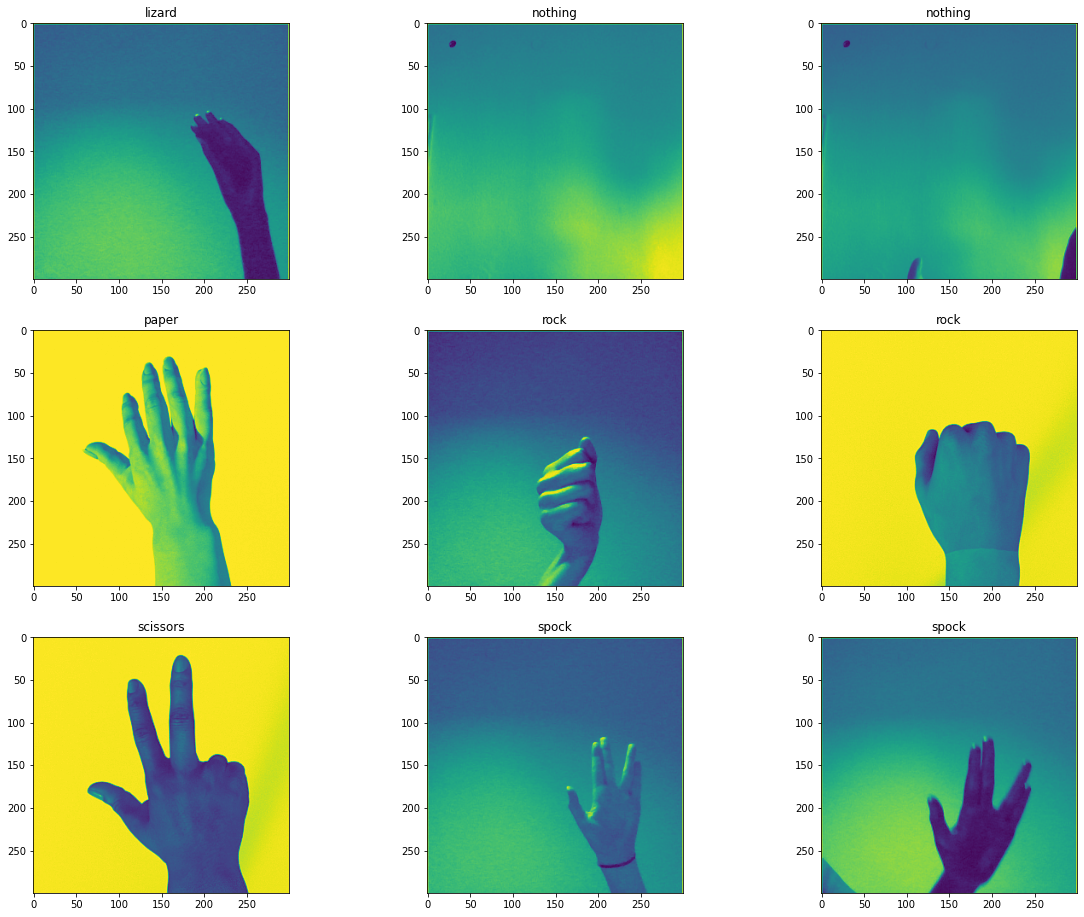

In [8]:
fig = plt.figure(figsize=(20,16))
for i in range(1, 10):
        fig.add_subplot(3, 3, i)
        image = dataset[i*999][0]
        plt.title(dataset[i*999][1])
        plt.imshow(image)
plt.show()

In [ ]:
data, labels = zip(*dataset)
target = []
for label in labels:
    target.append(class_map[label])

In [ ]:
data = shuffle(data, random_state = 0)

In [ ]:
x_train_val, x_test, y_train_val, y_test = model_selection.train_test_split(data, target, test_size = 0.33, \
                                                                            stratify = target, random_state = 0)

In [ ]:
x_train, x_val, y_train, y_val = model_selection.train_test_split(x_train_val, y_train_val, test_size = 0.2, \
                                                                            stratify = y_train_val, random_state = 0)

In [ ]:
x_train = np.array(x_train).astype('float32') / 255
x_val = np.array(x_val).astype('float32') / 255
x_test = np.array(x_test).astype('float32') / 255

In [ ]:
num_of_classes = len(class_map)
y_train = utils.to_categorical(y_train, num_of_classes)
y_val = utils.to_categorical(y_val, num_of_classes)
y_test = utils.to_categorical(y_test, num_of_classes)

In [ ]:
x_train = x_train.reshape(x_train.shape[0], 300, 300, 1)
x_val = x_val.reshape(x_val.shape[0], 300, 300, 1)
x_test = x_test.reshape(x_test.shape[0], 300, 300, 1)

# Initial convolutional neural network

In [ ]:
model = Sequential([
    InputLayer(input_shape=(300,300,1)),
    Convolution2D(64, 3, activation='relu'),
    Convolution2D(32, 3, activation='relu'),
    MaxPooling2D(2,2),
    Dropout(0.5),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(6, activation='softmax')
])

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss=CategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
history = model.fit(x_train, y_train, epochs=20, batch_size=32, validation_data=(x_val, y_val), verbose=1)

# Second convolutional neural network

In [ ]:
model2 = Sequential([
    InputLayer(input_shape=(300,300,1)),
    Convolution2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Convolution2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'),
    AveragePooling2D(pool_size=(2, 2)),
    Convolution2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(6, activation='softmax')
])

In [ ]:
model2.compile(optimizer=Adam(learning_rate=0.0001),
              loss=CategoricalCrossentropy(),
              metrics=['accuracy'])


In [ ]:
history2=model2.fit(x_train, y_train, epochs=5, batch_size=32)

# Hyperparameter Tuning

In [ ]:
pip install -U keras_tuner

In [ ]:
from kerastuner.tuners import RandomSearch

def build_model(hp):
    model = Sequential()

    model.add(MaxPooling2D(6,3,input_shape=(300,300,1)))

    for i in range(hp.Int("Conv Layers", min_value=0, max_value=3)):
    model.add(Convolution2D(hp.Choice(f"layer_{i}_filters", [16,32,64]), 3, activation='relu'))
  
    model.add(MaxPooling2D(2,2))
    model.add(Dropout(0.5))
    model.add(Flatten())

    model.add(Dense(hp.Choice("Dense layer", [64, 128, 256, 512, 1024]), activation='relu'))

    model.add(Dense(6, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=0.0001),
              loss=CategoricalCrossentropy(),
              metrics=['accuracy'])
  
  return model

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=32,
)

tuner.search(x_train, y_train, validation_data=(x_val, y_val), epochs=10, batch_size=32)

# Game

In [ ]:
from tensorflow.keras.models import load_model
import cv2
import numpy as np
from random import choice

In [ ]:
class_map = {
    0: "rock",
    1: "paper",
    2: "scissors",
    3: "lizard",
    4: "spock",
    5: "nothing"
}

In [ ]:
def class_name(index):
    return class_map[index]

In [ ]:
#staviti pre ovoga proveru da li je nothing move1 ili move2
def who_wins(move1, move2, player1, player2):
    if move1 == move2:
        return "Tie"

    if move1 == "rock":
        if move2 == "paper":
            return player2
        if move2 == "scissors":
            return player1
        if move2 == "lizard":
            return player1
        if move2 == "spock":
            return player2

    if move1 == "paper":
        if move2 == "rock":
            return player1
        if move2 == "scissors":
            return player2
        if move2 == "lizard":
            return player2
        if move2 == "spock":
            return player1

    if move1 == "scissors":
        if move2 == "rock":
            return player2
        if move2 == "paper":
            return player1
        if move2 == "lizard":
            return player1
        if move2 == "spock":
            return player2
        
    if move1 == "lizard":
        if move2 == "rock":
            return player2
        if move2 == "paper":
            return player1
        if move2 == "scissors":
            return player2
        if move2 == "spock":
            return player1

    if move1 == "spock":
        if move2 == "rock":
            return player1
        if move2 == "paper":
            return player2
        if move2 == "scissors":
            return player1
        if move2 == "lizard":
            return player2

In [ ]:
captured_image = cv2.VideoCapture(0) # 0 -> open default camera

In [ ]:
prev_move = None

while True:
    retval, frame = captured_image.read() # Grabs, decodes and returns the next video frame.
    if not retval:
        continue
    
    window_height = frame.shape[0]
    window_width = frame.shape[1]
    
    # rectangle for user to play
    #def: cv2.rectangle(image, start_point, end_point, color, thickness), we set color in RGB format
    cv2.rectangle(frame, (0, 0), (int(window_width * .40), int(window_height * .60)), (255, 255, 255), 2) 
    # rectangle for computer to play
    cv2.rectangle(frame, (int(window_width * .60), 0), (window_width, int(window_height * .60)), (255, 255, 255), 2)
    
    window_name = "Rock Paper Scissors Lizard Spock"
    cv2.namedWindow(window_name, cv2.WND_PROP_FULLSCREEN)
    cv2.setWindowProperty(window_name, cv2.WND_PROP_FULLSCREEN, cv2.WINDOW_FULLSCREEN)

    # extract the region of image within the user rectangle
    roi = frame[0:int(window_height * .60), 0:int(window_width * .40)]
    
    # TODO: delete
    import matplotlib.pyplot as plt
    plt.imshow(roi)
    plt.show()
    
    img = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (300, 300))
    
    # additional preparation of data
    img = img.reshape(300, 300, 1)
    img = np.array([img]).astype('float32')
    img /= 255
    
    # predict the move made
    pred = model.predict(img)
    move_class = np.argmax(pred[0])
    print(pred[0], move_class) # TODO: delete
    user_move_name = class_name(move_class)
    
    print(prev_move, user_move_name) # TODO: delete
    
    # predict the winner (human vs computer)
    if prev_move != user_move_name:
        if user_move_name != "nothing":
            computer_move_name = choice(['rock', 'paper', 'scissors', 'lizard', 'spock'])
            winner = who_wins(user_move_name, computer_move_name, "User", "computer")
        else:
            computer_move_name = "nothing"
            winner = "Waiting..."
    prev_move = user_move_name

    # display the information
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(frame, "Your Move: " + user_move_name,
                (int(window_width * .05), int(window_height * .65)),
                font, 0.5, (255, 255, 255), 2, cv2.LINE_AA)
    cv2.putText(frame, "Computer's Move: " + computer_move_name,
                (int(window_width * .65), int(window_height * .65)),
                font, 0.5, (255, 255, 255), 2, cv2.LINE_AA)
    cv2.putText(frame, "Winner: " + winner,
                (int(window_width * .40), int(window_height * .90)),
                font, 0.75, (0, 0, 255), 4, cv2.LINE_AA)

    if computer_move_name != "nothing":
        icon = cv2.imread(
            "images/{}.png".format(computer_move_name))
        icon = cv2.resize(icon, (int(window_width-int(window_width * .60)), int(window_height * .60)))

        frame[0:int(window_height * .60), int(window_width * .60):window_width] = icon

    cv2.imshow(window_name, frame)

    k = cv2.waitKey(10)
    if k == ord('q'):
        break

captured_image.release()
cv2.destroyAllWindows()